In [11]:
import pandas_datareader as pdr
import pandas as pd

In [12]:
def get_data():
    temp = pdr.get_data_yahoo('INFY')
    temp.to_csv('C:\Codes\Time-Series\Data\infosys.csv')
    return True
get_data() #To work with data extracted.

True

# EDA

In [13]:
df = pd.read_csv('C:\Codes\Time-Series\Data\infosys.csv')    #Reading the data.
df.index = pd.to_datetime(df['Date'], format = "%Y.%m.%d")   #Changing index to datetime dtype.
df.drop(columns='Date', inplace=True)                        #Dropping the existing date column.
print(df.head())

             High    Low   Open  Close      Volume  Adj Close
Date                                                         
2017-07-12  7.830  7.710  7.750  7.820  21274600.0   6.827609
2017-07-13  7.825  7.735  7.775  7.780  20329000.0   6.792686
2017-07-14  7.965  7.750  7.775  7.835  23331800.0   6.840705
2017-07-17  7.870  7.730  7.860  7.820  14512400.0   6.827609
2017-07-18  7.840  7.710  7.800  7.775  12970800.0   6.788319


In [14]:
print(df.tail())

                 High        Low       Open      Close      Volume  Adj Close
Date                                                                         
2022-07-05  18.690001  18.360001  18.510000  18.670000  10265200.0  18.670000
2022-07-06  19.020000  18.700001  18.700001  18.930000   8860200.0  18.930000
2022-07-07  19.180000  18.900000  18.990000  19.160000   9675500.0  19.160000
2022-07-08  19.160000  18.760000  19.049999  19.059999  15835100.0  19.059999
2022-07-11  18.590000  18.230000  18.500000  18.459999   7908800.0  18.459999


In [15]:
print(df.describe())

              High          Low         Open        Close        Volume  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1.258000e+03   
mean     13.597333    13.367369    13.481657    13.485358  1.047395e+07   
std       5.507180     5.419010     5.464274     5.465932  6.564810e+06   
min       7.155000     6.760000     6.920000     6.940000  1.320600e+06   
25%       9.370000     9.170000     9.252500     9.270000  6.531225e+06   
50%      10.870000    10.725000    10.815000    10.770000  8.877450e+06   
75%      18.532499    18.172500    18.342500    18.352500  1.251438e+07   
max      26.389999    25.580000    26.150000    26.200001  7.716540e+07   

         Adj Close  
count  1258.000000  
mean     12.854244  
std       5.664382  
min       6.225172  
25%       8.578665  
50%      10.000537  
75%      17.876713  
max      25.910423  


In [16]:
print(df.isnull().any(axis=0))  #No null values.

High         False
Low          False
Open         False
Close        False
Volume       False
Adj Close    False
dtype: bool


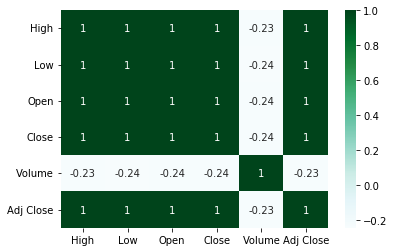

In [17]:
import seaborn as sns
sns.heatmap(df.corr(), cmap = 'BuGn', annot=True)

In [18]:
#We are only going to be working with the close value.
df.drop(columns=['Volume','High','Low','Open','Adj Close'], inplace=True)

In [19]:
df.head()

,Close
Date,
2017-07-12,7.820
2017-07-13,7.780
2017-07-14,7.835
2017-07-17,7.820
2017-07-18,7.775


In [20]:
#Saving it to a different csv file.
df.to_csv('C:\Codes\Time-Series\Data\closeInfosys.csv')

# Data-Preprocessing

In [21]:
closeDF = pd.read_csv('C:\Codes\Time-Series\Data\closeInfosys.csv')
print(closeDF.head())

         Date  Close
0  2017-07-12  7.820
1  2017-07-13  7.780
2  2017-07-14  7.835
3  2017-07-17  7.820
4  2017-07-18  7.775


In [22]:
closeDF.set_index(closeDF['Date'],drop=True, inplace=True)  #Setting the index column as the date column.

In [23]:
closeDF.drop(columns='Date', inplace=True)                  #Dropping the existing date column.

In [24]:
print(closeDF.head())

            Close
Date             
2017-07-12  7.820
2017-07-13  7.780
2017-07-14  7.835
2017-07-17  7.820
2017-07-18  7.775


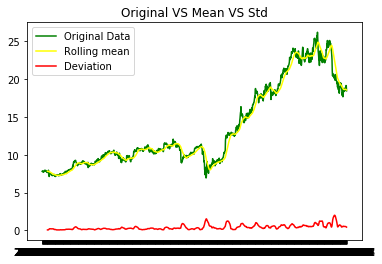

In [25]:
#Getting the moving average and deviation.
data_mean = closeDF['Close'].rolling(window=23).mean()
data_std = closeDF['Close'].rolling(window=23).std()

#Plotting the results.
from matplotlib import pyplot as plt
plt.plot(closeDF['Close'], color='green', label='Original Data')
plt.plot(data_mean, color="yellow", label="Rolling mean")
plt.plot(data_std, color='red', label='Deviation')
plt.legend(loc='best')
plt.title('Original VS Mean VS Std')
plt.show()

In [27]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

#Normalizing the data.
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(closeDF['Close']).reshape(-1,1))
print(df1.shape)

(1258, 1)


In [28]:
closeDF.dropna(inplace=True) #Dropping all the null values.

In [29]:
def split_data(data): 

    '''
    A function to split the data into  train and validation sets.
    '''
    train_size = int(len(data) * 0.75)
    test_size = int(len(data) - train_size)
    train_data, test_data = data[0:train_size,:],data[train_size:len(df1),:1]
    print(train_size, test_size)
    return train_data, test_data

In [30]:
X,Y = split_data(df1) #Splitting the data into train and validation sets.

943 315


In [31]:
#Saving the numpy arrays in a csv file.
np.savetxt('C:\\Codes\\Time-Series\\Data\\train_data.csv', X)
np.savetxt('C:\\Codes\\Time-Series\\Data\\test_data.csv', Y)

In [32]:
#Reading the data saved earlier.
x = pd.read_csv("C:\\Codes\\Time-Series\\Data\\train_data.csv")  #Train Data.
y = pd.read_csv("C:\\Codes\\Time-Series\\Data\\test_data.csv")   #Test Data.

In [33]:
def dataset_matrix(dataset, timestep):
    '''
    Function to generate a data matrix depending upon the time stamps taken into consideration for the forecasting.
    '''
    X_data, Y_data = [], []
    for i in range(len(dataset)-timestep-1):
        flag_X = dataset.iloc[i:(i+timestep), 0]
        flag_Y = dataset.iloc[(i+timestep),0]
        X_data.append(flag_X)
        Y_data.append(flag_Y)
    return np.array(X_data), np.array(Y_data)

In [71]:
timestep = 60
Xtrain, Ytrain = dataset_matrix(x, timestep)
Xtest, Ytest = dataset_matrix(y, timestep)

In [72]:
print(Xtrain.shape,'\n',Ytrain.shape,'\n',Xtest.shape,'\n',Ytest.shape)

(881, 60) 
 (881,) 
 (253, 60) 
 (253,)


In [73]:
#Reshaping the data to feed it into the LSTM model.
Xtrain = Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1], 1) 
Xtest = Xtest.reshape(Xtest.shape[0], Xtest.shape[1], 1)

# Bulding the Model.

In [81]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

#Bulding blocks of the model.
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(60,1)))
model.add(Dropout(0.5))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(25, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 100)           40800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 50)            30200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dropout_8 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [82]:
from keras.callbacks import CSVLogger, ModelCheckpoint,EarlyStopping  
csv_logger = CSVLogger('training.log', separator = ';')
checkpoint = ModelCheckpoint('lstm_model.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)
early = EarlyStopping(monitor = 'val_loss', patience = 10)

In [83]:
#Fitting the model with the dataset at hand.
model.fit(Xtrain, Ytrain, validation_data = (Xtest, Ytest), epochs = 50, batch_size = 32,verbose=1, callbacks=[csv_logger, checkpoint])

Epoch 1/50
28/28 [==============================] - 13s 177ms/step - loss: 0.0078 - val_loss: 0.0036

Epoch 00001: val_loss improved from inf to 0.00360, saving model to lstm_model.h5
Epoch 2/50
28/28 [==============================] - 3s 126ms/step - loss: 0.0025 - val_loss: 0.0034

Epoch 00002: val_loss improved from 0.00360 to 0.00337, saving model to lstm_model.h5
Epoch 3/50
28/28 [==============================] - 3s 118ms/step - loss: 0.0022 - val_loss: 0.0049

Epoch 00003: val_loss did not improve from 0.00337
Epoch 4/50
28/28 [==============================] - 4s 131ms/step - loss: 0.0020 - val_loss: 0.0030

Epoch 00004: val_loss improved from 0.00337 to 0.00304, saving model to lstm_model.h5
Epoch 5/50
28/28 [==============================] - 4s 129ms/step - loss: 0.0020 - val_loss: 0.0033

Epoch 00005: val_loss did not improve from 0.00304
Epoch 6/50
28/28 [==============================] - 3s 116ms/step - loss: 0.0017 - val_loss: 0.0028

Epoch 00006: val_loss improved from 0

## Evaluation of the Model.

In [84]:
#Predicting values.
train_predict = model.predict(Xtrain)
test_predict = model.predict(Xtest)

In [85]:
#Converting the normalized predictions to their original form.
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [86]:
from keras.losses import MeanSquaredError
metric = MeanSquaredError(reduction='auto', name='mean_squared_error')
metric(Ytrain, train_predict).numpy()

119.430565

In [87]:
metric(Ytest, test_predict).numpy()

467.56036

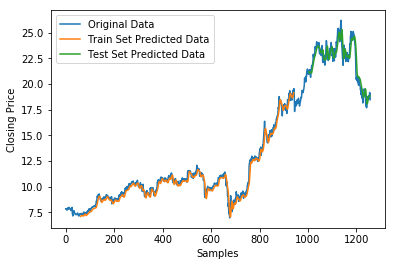

In [89]:
#Evaluation of the model on train and test data.

look_back=61
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1), label='Original Data')
plt.plot(trainPredictPlot, label='Train Set Predicted Data')
plt.plot(testPredictPlot, label='Test Set Predicted Data')
plt.xlabel('Samples')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [90]:
len(y)

314

In [91]:
x_input=np.array(y[254:]).reshape(1,-1)
x_input.shape

(1, 60)

In [92]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.7398753870557138,
 0.7019729248108293,
 0.7071650524227475,
 0.6998961331850204,
 0.7076842750870989,
 0.7133956253633686,
 0.6915887686185904,
 0.6993769105206689,
 0.6843198493808631,
 0.6843198493808631,
 0.7040498154682355,
 0.6713395798668664,
 0.6858774183423209,
 0.689511877961184,
 0.7097611657445049,
 0.6941847829087505,
 0.6703011345381633,
 0.6687434665451086,
 0.6656282295905969,
 0.6474558324646817,
 0.6536864054053031,
 0.649532723122088,
 0.6230529614297429,
 0.657840087688518,
 0.6147455968633129,
 0.6069573559296371,
 0.6105919145800978,
 0.6204568481079855,
 0.5950155317443436,
 0.5815160395659953,
 0.5976116450661011,
 0.6261681983842549,
 0.6188992791465278,
 0.6277258663773095,
 0.6526479600766002,
 0.6458981644716273,
 0.6484942777933849,
 0.6458981644716273,
 0.6344755629506851,
 0.6199376254436337,
 0.5913810721254795,
 0.5664589784261893,
 0.5867081671779131,
 0.5893042804996709,
 0.5571131685310562,
 0.5617860734786229,
 0.6142263741989613,
 0.5908618494611

In [94]:
from numpy import array

lst_output=[]
n_steps=60
i=0
while(i<30):
    
    if(len(temp_input))>60:
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.6220093]
61
1 day input [0.70197292 0.70716505 0.69989613 0.70768428 0.71339563 0.69158877
 0.69937691 0.68431985 0.68431985 0.70404982 0.67133958 0.68587742
 0.68951188 0.70976117 0.69418478 0.67030113 0.66874347 0.66562823
 0.64745583 0.65368641 0.64953272 0.62305296 0.65784009 0.6147456
 0.60695736 0.61059191 0.62045685 0.59501553 0.58151604 0.59761165
 0.6261682  0.61889928 0.62772587 0.65264796 0.64589816 0.64849428
 0.64589816 0.63447556 0.61993763 0.59138107 0.56645898 0.58670817
 0.58930428 0.55711317 0.56178607 0.61422637 0.59086185 0.59709242
 0.60903425 0.61370715 0.59813077 0.60591901 0.60072688 0.61838006
 0.60903425 0.62253374 0.63447556 0.62928344 0.59813077 0.62200928]
1 day output [[0.622751]]
2 day input [0.70716505 0.69989613 0.70768428 0.71339563 0.69158877 0.69937691
 0.68431985 0.68431985 0.70404982 0.67133958 0.68587742 0.68951188
 0.70976117 0.69418478 0.67030113 0.66874347 0.66562823 0.64745583
 0.65368641 0.64953272 0.62305296 0.65784009 0.6147456  0.606957

In [95]:
day_new=np.arange(1,61)
day_pred=np.arange(61,91)

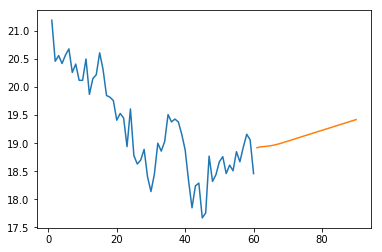

In [96]:
plt.plot(day_new,scaler.inverse_transform(df1[1198:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

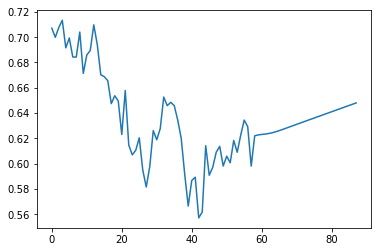

In [97]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

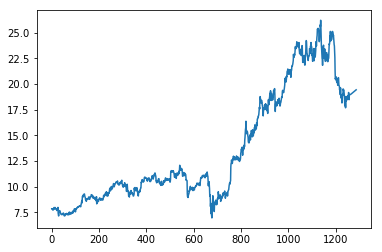

In [98]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)